# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout my practical applications, I will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  My first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, I am tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, I am asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

This is a **supervised regression** task. The target variable is `price` (continuous), and the features include vehicle attributes such as year, manufacturer, model, condition, cylinders, fuel type, odometer reading, title status, transmission, drive type, size, vehicle type, and paint color, as well as geographic variables like region and state. My goal is to fit regression models that predict price from these features, then interpret the learned coefficients and feature importances to identify which factors have the greatest positive or negative effect on a used car's market value. The success criterion is a model that generalizes well (measured via cross-validated error metrics such as RMSE and R²) and whose feature-level insights can be translated into clear, actionable inventory recommendations for the dealership.

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV


def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"--- {column.upper()} ---")
    print(f"Lower Bound: {lower_bound:.2f} | Upper Bound: {upper_bound:.2f}")
    print(f"Total Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}% of data)\n")
    return outliers


def drop_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before = len(df)
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"drop_outliers({column}): {before} -> {len(df)} rows (removed {before - len(df)})")
    return df



def create_regressor(model, preprocessor):
    return TransformedTargetRegressor(
        regressor=Pipeline([('preprocessor', preprocessor), ('model', model)]),
        func=np.log1p,
        inverse_func=np.expm1)


def print_metrics(y_train, train_preds, y_test, test_preds, label="Model"):
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    print(f"\n--- {label} ---")
    print(f"Train MSE:  {train_mse:>15,.2f}  |  Test MSE:  {test_mse:>15,.2f}")
    print(f"Train MAE:  {train_mae:>15,.2f}  |  Test MAE:  {test_mae:>15,.2f}")
    print(f"Train RMSE: ${np.sqrt(train_mse):>14,.2f}  |  Test RMSE: ${np.sqrt(test_mse):>14,.2f}")
    print(f"Train R²:   {train_r2:>15.4f}  |  Test R²:   {test_r2:>15.4f}")
    return {
        'label': label,
        'train_mse': train_mse, 'test_mse': test_mse,
        'train_mae': train_mae, 'test_mae': test_mae,
        'train_r2': train_r2, 'test_r2': test_r2,
    }


def run_model(model, X_train, y_train, X_test, y_test, label="Model",
              param_grid=None, cv=5):
    """Build a pipeline, fit, predict, and print metrics. Optionally tune with GridSearchCV.

    Returns the fitted model (or GridSearchCV object if param_grid is provided).
    """
    cat_features = X_train.select_dtypes(include='object').columns.tolist()
    num_features = X_train.select_dtypes(include='number').columns.tolist()

    print(f"Features ({len(cat_features)} cat + {len(num_features)} num): "
          f"{cat_features + num_features}")

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features),
        ('num', StandardScaler(), num_features),
    ])

    regressor = create_regressor(model, preprocessor)

    if param_grid:
        fitted = GridSearchCV(regressor, param_grid=param_grid,
                              cv=cv, scoring='neg_mean_squared_error')
        fitted.fit(X_train, y_train)
        print(f"Best params: {fitted.best_params_}")
    else:
        fitted = regressor
        fitted.fit(X_train, y_train)

    train_preds = fitted.predict(X_train)
    test_preds = fitted.predict(X_test)

    metrics = print_metrics(y_train, train_preds, y_test, test_preds, label=label)
    return fitted, metrics

### Data Understanding

After considering the business understanding, I want to get familiar with the data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

*Step 1*: Read in the vehicles.csv file.


In [248]:
df = pd.read_csv('data/vehicles.csv')

# Display the first few rows of the dataset
print(f"df.head(): \n{df.head()}")
print(f"\n\n")
print(f"df.tail(): \n{df.tail()}")


df.head(): 
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         Na

*Step 2*: Investigate the dataset for missing or problematic data.

In [249]:
# get number of rows and columns of dataframe
print("\nNumber of rows, columns:")
print(df.shape)

# data schema
print("\n\nData Schema:")
df.info()

# descriptive stats
print("\n\nDescriptive Statistics of Numerical Variables:")
df.describe()




Number of rows, columns:
(426880, 18)


Data Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [250]:
# more descriptive stats
print("\n\nDescriptive Statistics of Categorical Variables")
df.describe(include=['object', 'category'])




Descriptive Statistics of Categorical Variables


,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


In [251]:
# discover missing values in columns
print(df.isnull().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


*Step 3*: Decide what to do about your missing data -- drop, replace, other...

In [252]:
# "size" column has the most null values, so let's drop this column
df.drop(columns=['size'], axis=1, inplace=True)

# drop "VIN" column, it is not a useful feature
df.drop(columns=['VIN'], axis=1, inplace=True)

df.tail(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
426870,7301592119,wyoming,22990,2020.0,hyundai,sonata se sedan 4d,good,NaN,gas,3066.0,clean,other,fwd,sedan,blue,wy
426871,7301591639,wyoming,17990,2018.0,kia,sportage lx sport utility 4d,good,NaN,gas,34239.0,clean,other,NaN,SUV,NaN,wy
426872,7301591201,wyoming,32590,2020.0,mercedes-benz,c-class c 300,good,NaN,gas,19059.0,clean,other,rwd,sedan,white,wy
426873,7301591202,wyoming,30990,2018.0,mercedes-benz,glc 300 sport,good,NaN,gas,15080.0,clean,automatic,rwd,other,white,wy
426874,7301591199,wyoming,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,rwd,coupe,NaN,wy


Create utility functions plot_feature_distribution(), min_max_info() and distinct_info().

In [253]:
def plot_feature_distribution(dataframe):
    numeric_cols = dataframe.select_dtypes(include='number').columns.tolist()
    categorical_cols = dataframe.select_dtypes(include='object').columns.tolist()

    for col in numeric_cols:
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.hist(dataframe[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        plt.tight_layout()
        plt.show()

    for col in categorical_cols:
        counts = dataframe[col].value_counts().nlargest(30)
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(counts.index.astype(str), counts.values, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {col} (top 30)')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

#plot_feature_distribution(df)


def min_max_info(dataframe):
    numeric_cols = dataframe.select_dtypes(include='number').columns.tolist()
    for col in numeric_cols:
        print(f"{col:>20s}  |  min: {dataframe[col].min():>15,.2f}  |  max: {dataframe[col].max():>15,.2f}")

#min_max_info(df)

def distinct_info(dataframe):
    categorical_cols  = dataframe.select_dtypes(include='object').columns.tolist()
    for col in categorical_cols:
        print(f"{col:>20s}  |  distinct: {sorted(dataframe[col].unique())}")

#distinct_info(df)


def plot_heatmap(df, title='Correlation Heatmap'):
    df_numeric = df.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()


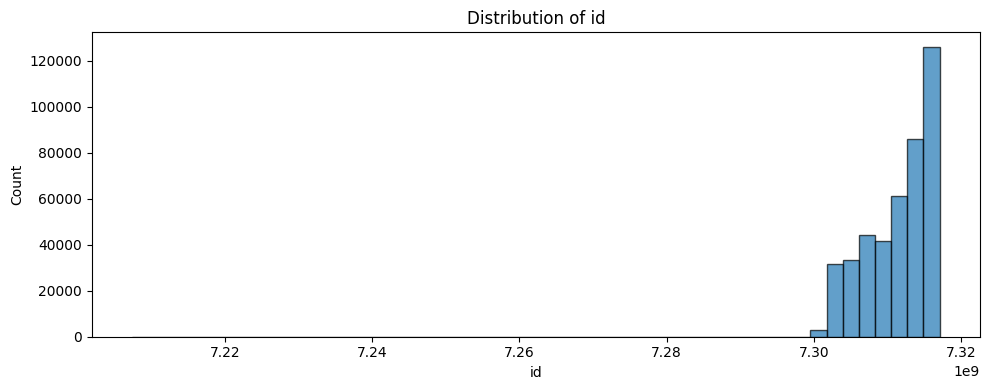

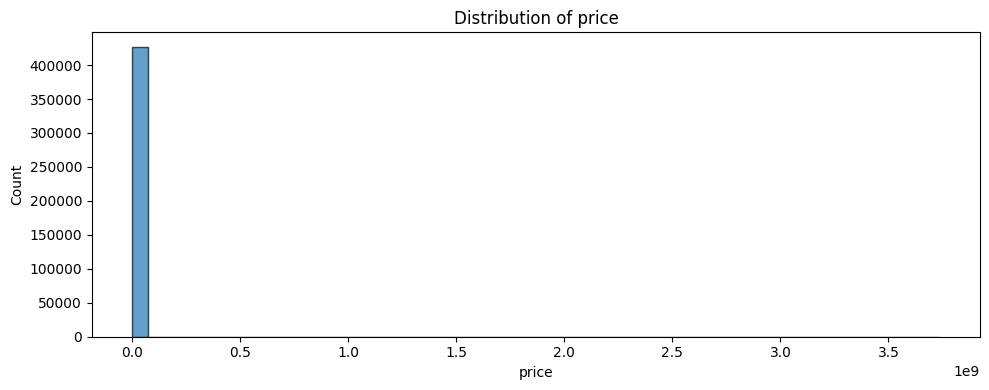

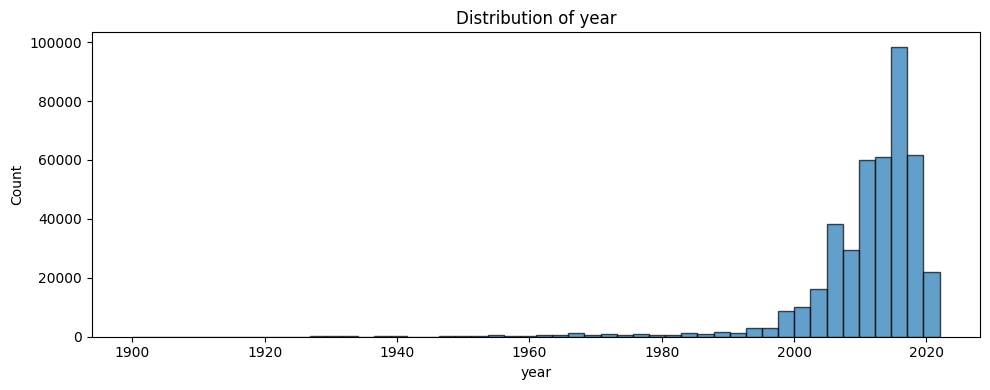

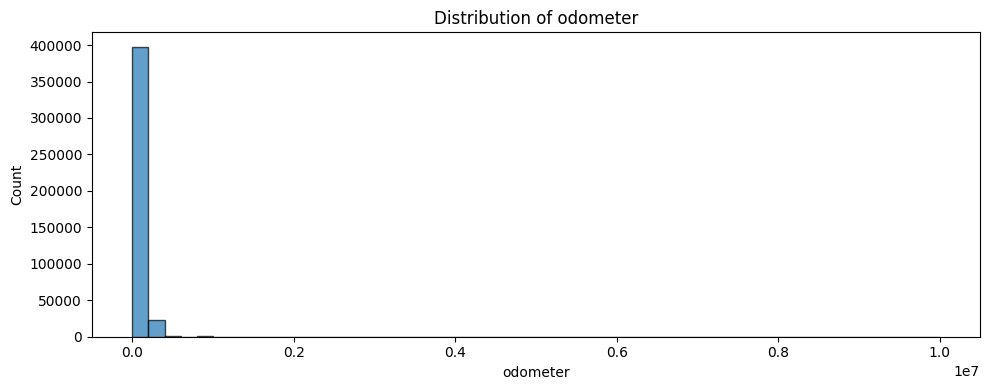

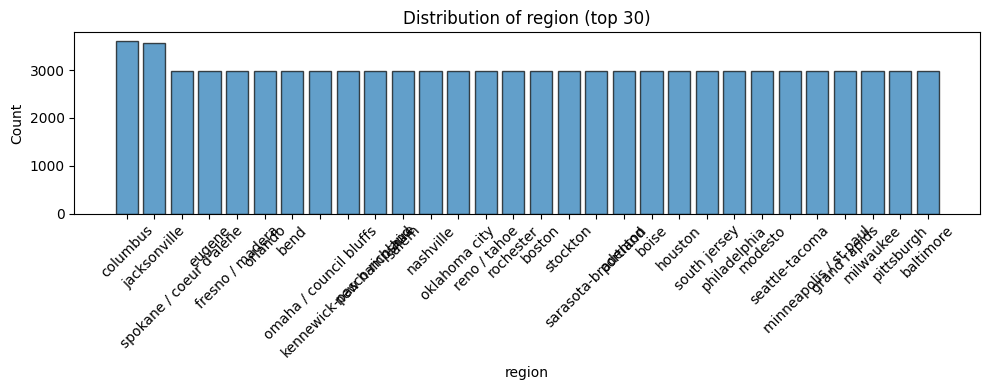

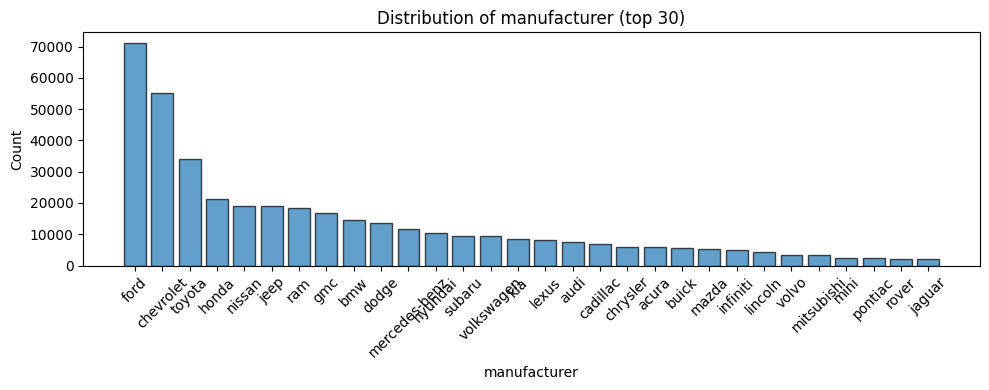

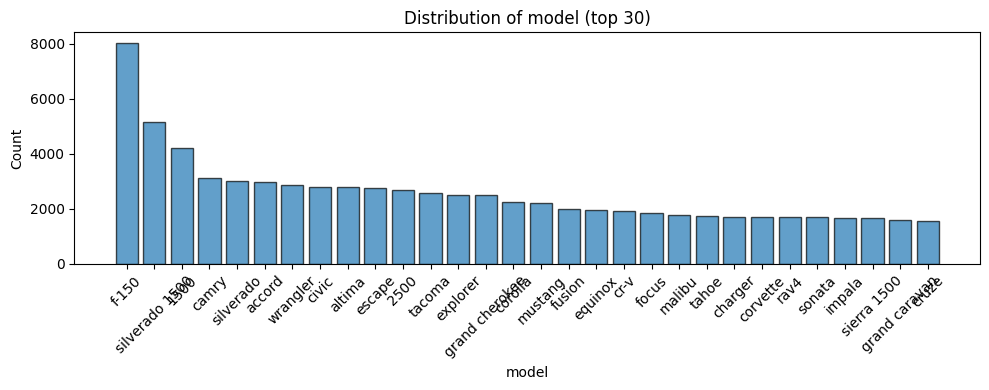

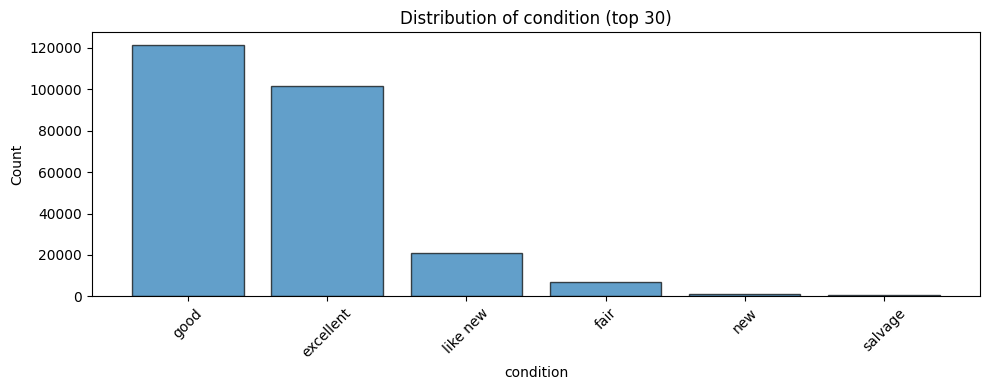

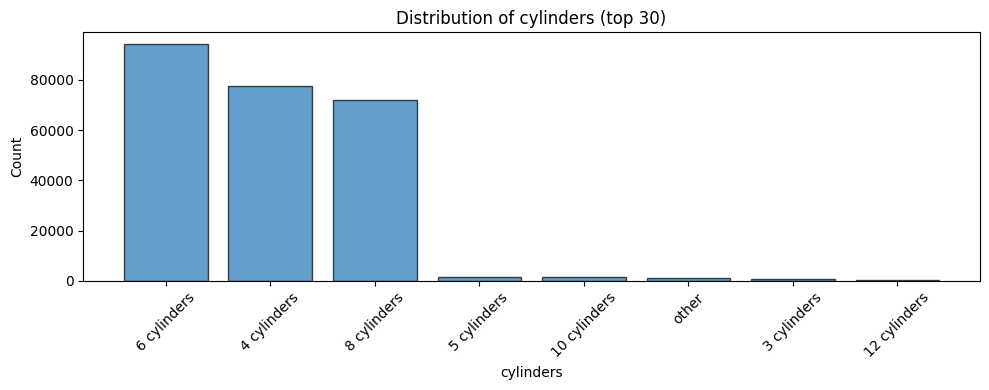

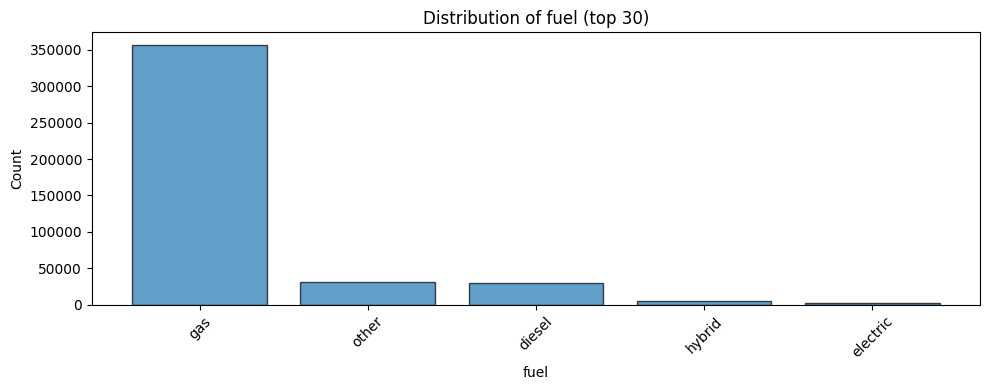

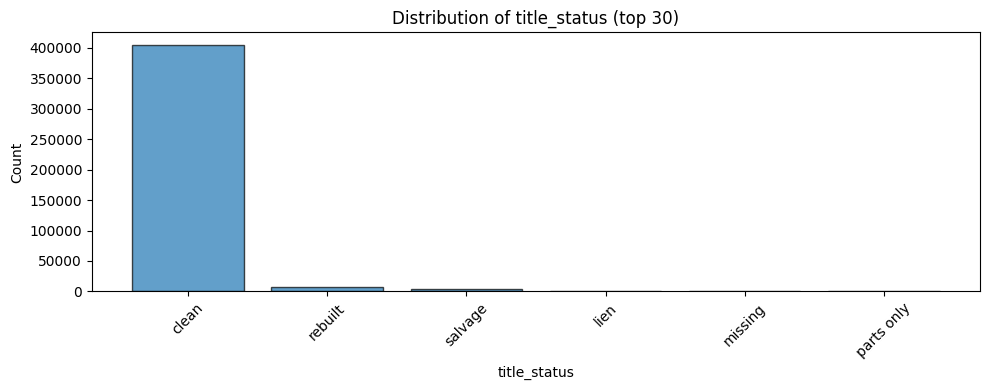

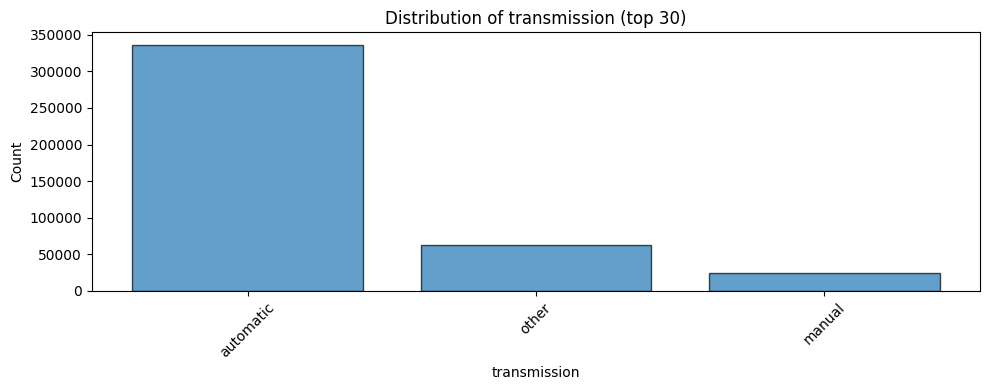

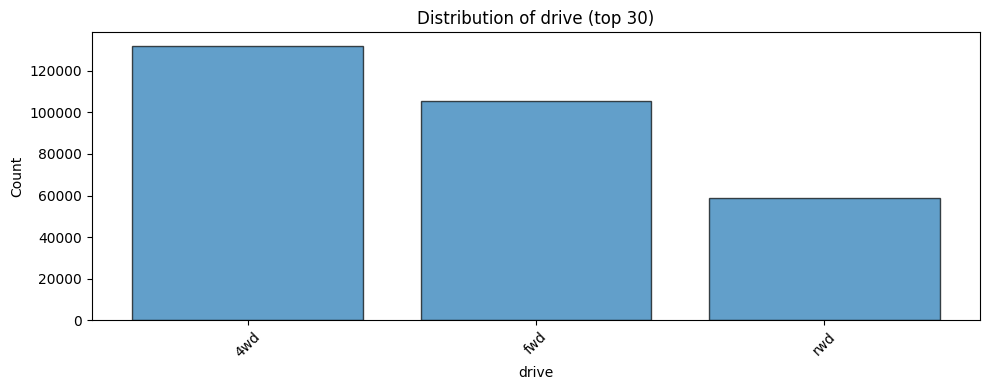

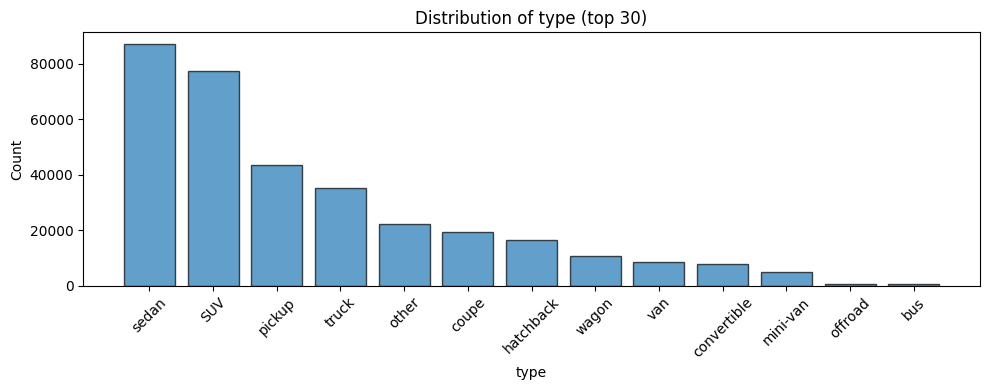

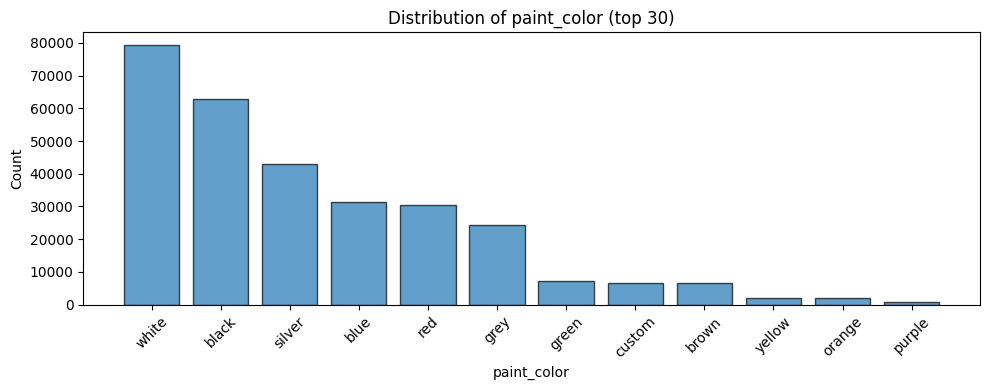

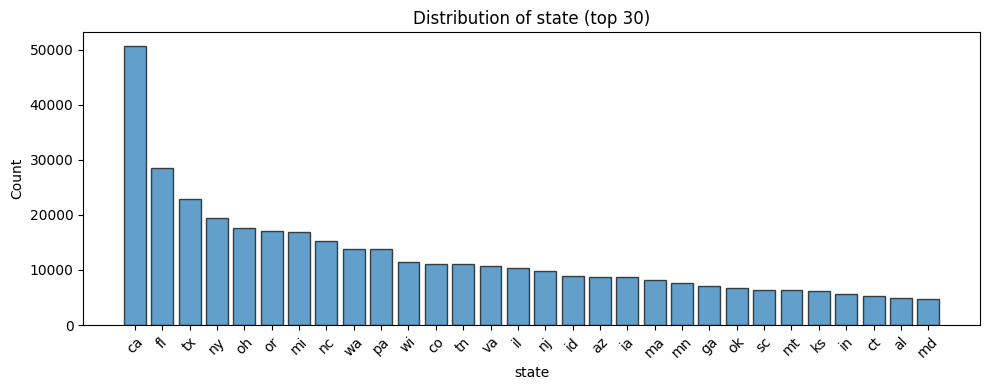

In [254]:
# plot the feature distribution
plot_feature_distribution(df)

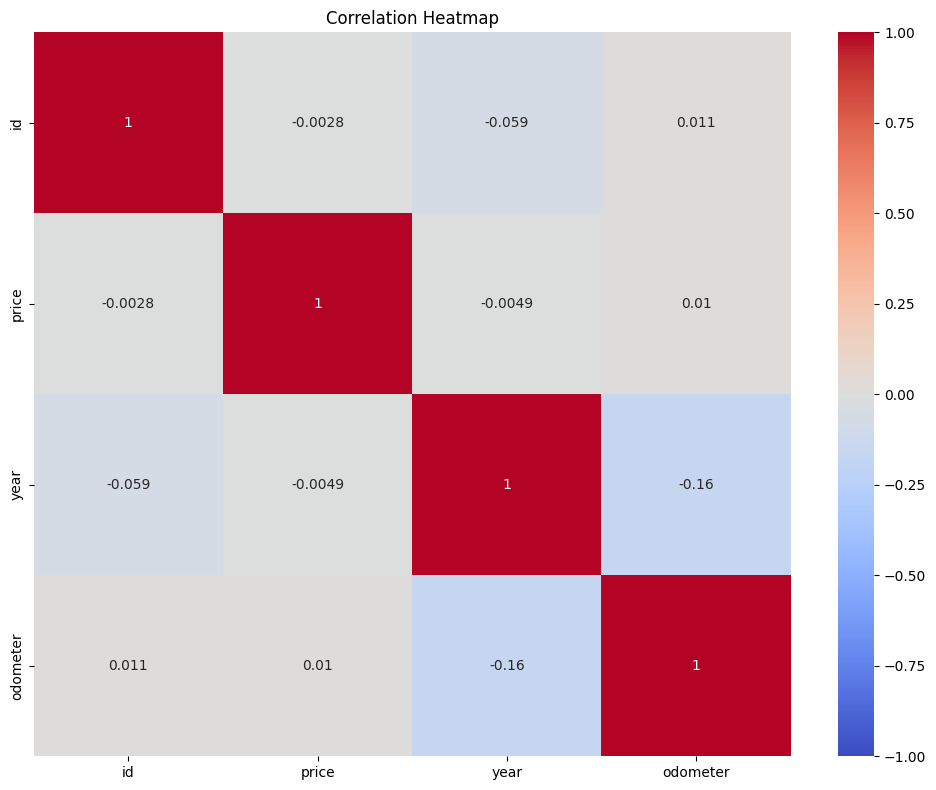

In [255]:
#plot the heatmap
plot_heatmap(df)

Based on heatmap, I can see year and odometer are highly correlated with price.

### Data Preparation

After my initial exploration and fine-tuning of the business understanding, it is time to construct the final dataset prior to modeling.  Here, I want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that I believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [256]:
print(f"Shape before cleaning: {df.shape}")

df = df.drop(columns=['id', 'VIN', 'region', 'state'], errors='ignore')

df = df[df['price'] > 0]
df = df[df['year'] >= 1990]

detect_outliers_iqr(df, 'price')
df = drop_outliers(df, 'price')

detect_outliers_iqr(df, 'odometer')
df = drop_outliers(df, 'odometer')

print(f"\nShape after removing outliers: {df.shape}")

Shape before cleaning: (426880, 16)
--- PRICE ---
Lower Bound: -23600.00 | Upper Bound: 58800.00
Total Outliers detected: 7118 (1.87% of data)

drop_outliers(price): 380667 -> 373549 rows (removed 7118)
--- ODOMETER ---
Lower Bound: -106169.00 | Upper Bound: 283615.00
Total Outliers detected: 3257 (0.87% of data)

drop_outliers(odometer): 373549 -> 368164 rows (removed 5385)

Shape after removing outliers: (368164, 13)


In [257]:
# Drop rows missing any important feature
df = df.dropna(subset=['year', 'manufacturer', 'odometer', 'fuel', 'transmission',
                       'title_status', 'condition', 'cylinders', 'drive', 'type', 'paint_color', 'model'])

print(f"Shape after handling missing values: {df.shape}")
print(f"\nRemaining nulls:\n{df.isnull().sum()}")

Shape after handling missing values: (105801, 13)

Remaining nulls:
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
dtype: int64


In [258]:
# Create 'vehicle_age' feature from "year" column, then drop "year" column
df['vehicle_age'] = 2026 - df['year']
df = df.drop(columns=['year'])

# Convert 'cylinders' from string to numeric
cyl_map = {
    '3 cylinders': 3, '4 cylinders': 4, '5 cylinders': 5,
    '6 cylinders': 6, '8 cylinders': 8, '10 cylinders': 10,
    '12 cylinders': 12, 'other': 0, 'unknown': 0
}
df['cylinders'] = df['cylinders'].map(cyl_map).fillna(0).astype(int)

detect_outliers_iqr(df, 'cylinders')
df = drop_outliers(df, 'cylinders')

print(f"Shape after feature engineering: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

--- CYLINDERS ---
Lower Bound: -2.00 | Upper Bound: 14.00
Total Outliers detected: 0 (0.00% of data)

drop_outliers(cylinders): 105801 -> 105801 rows (removed 0)
Shape after feature engineering: (105801, 13)

Columns: ['price', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'vehicle_age']


,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,vehicle_age
31,15000,ford,f-150 xlt,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,13.0
32,27990,gmc,sierra 2500 hd extended cab,good,8,gas,68696.0,clean,other,4wd,pickup,black,14.0
33,34590,chevrolet,silverado 1500 double,good,6,gas,29499.0,clean,other,4wd,pickup,silver,10.0
34,35000,toyota,tacoma,excellent,6,gas,43000.0,clean,automatic,4wd,truck,grey,7.0
35,29990,chevrolet,colorado extended cab,good,6,gas,17302.0,clean,other,4wd,pickup,red,10.0


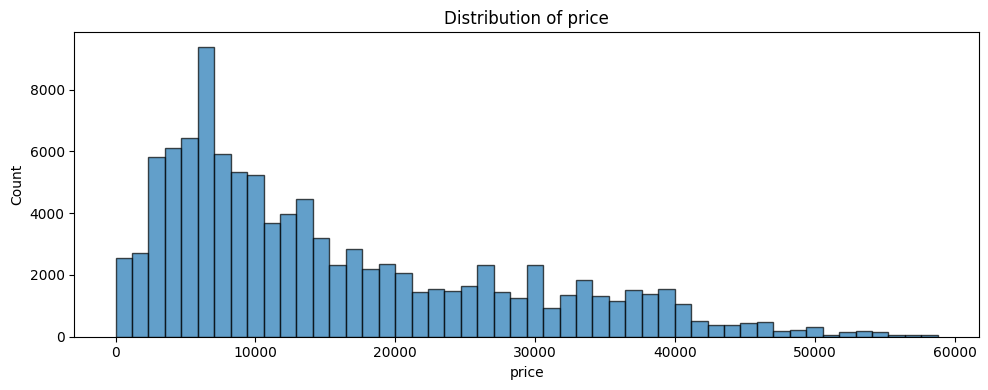

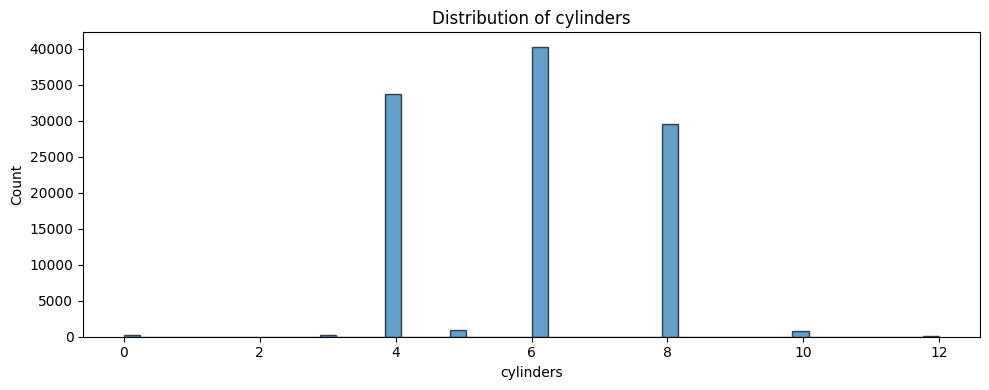

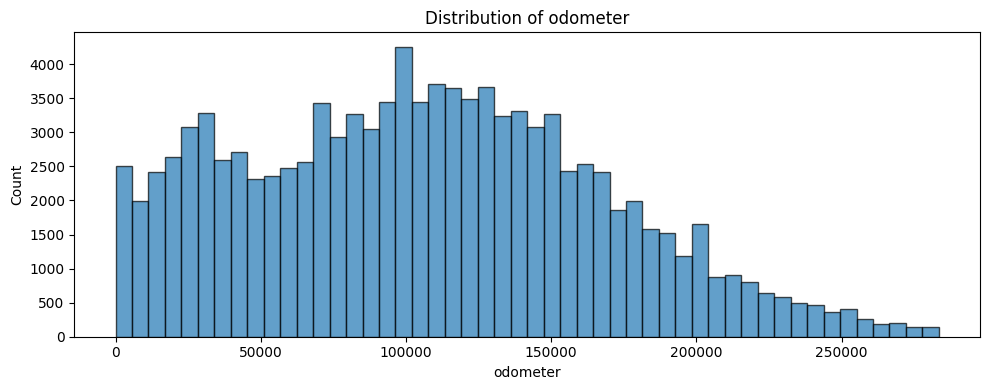

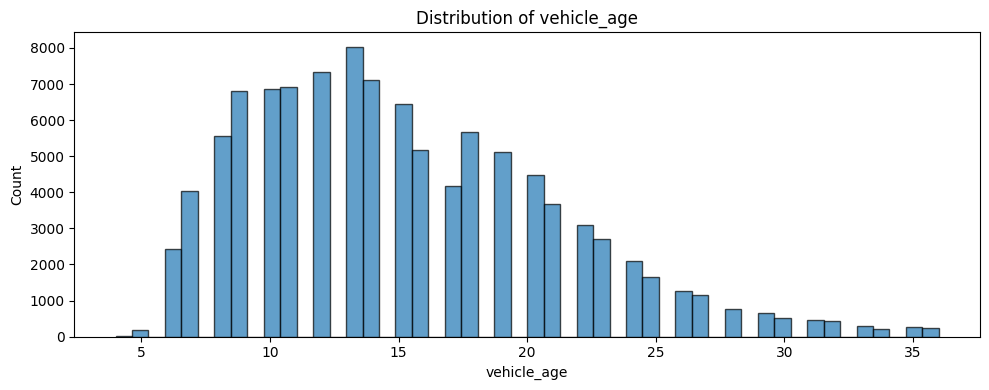

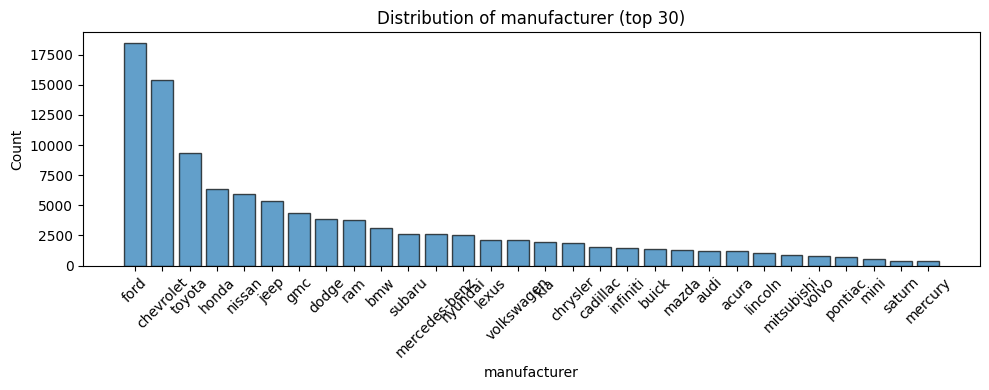

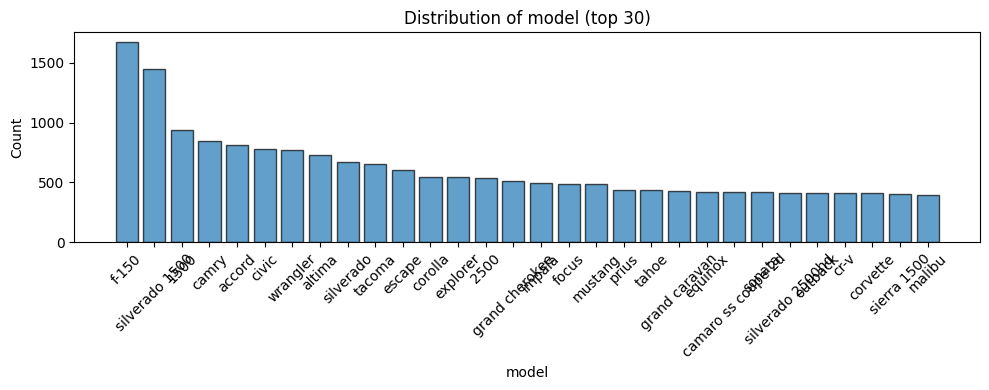

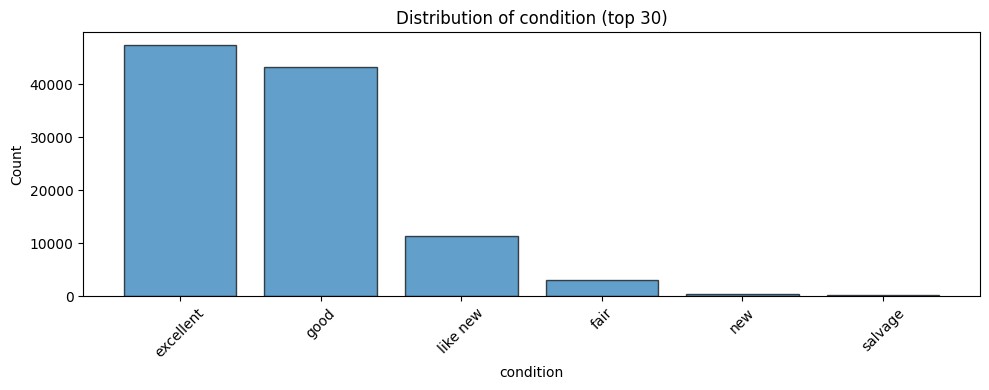

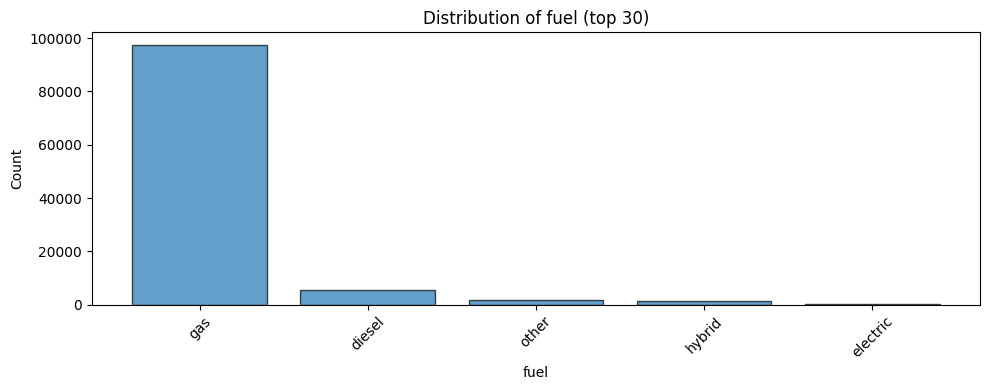

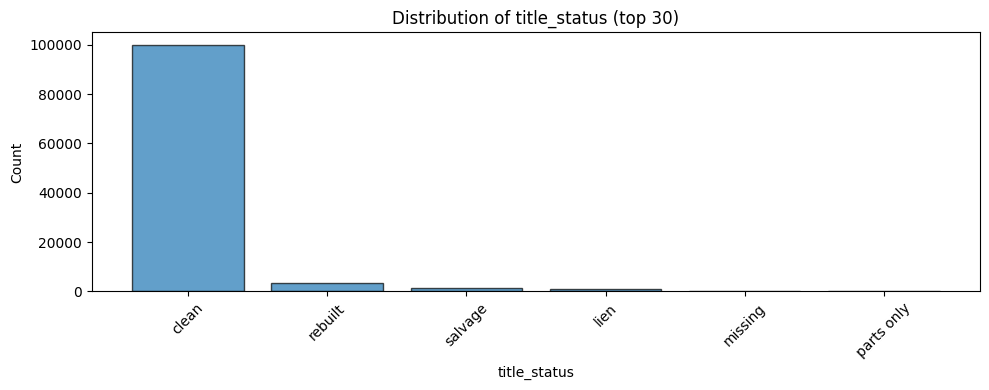

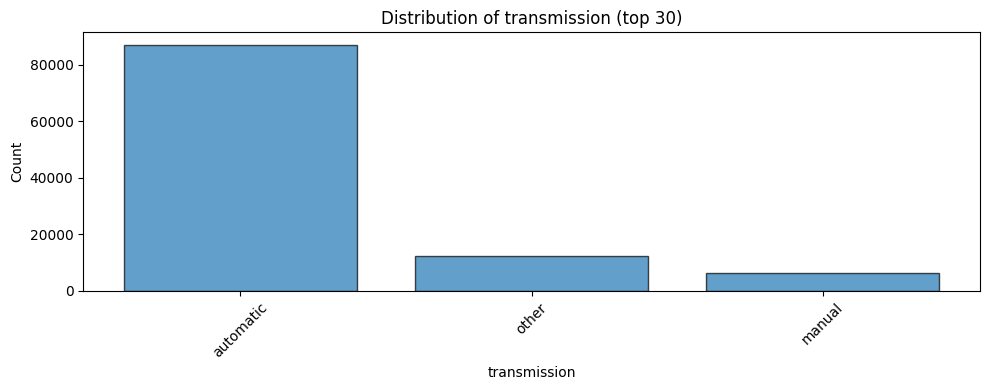

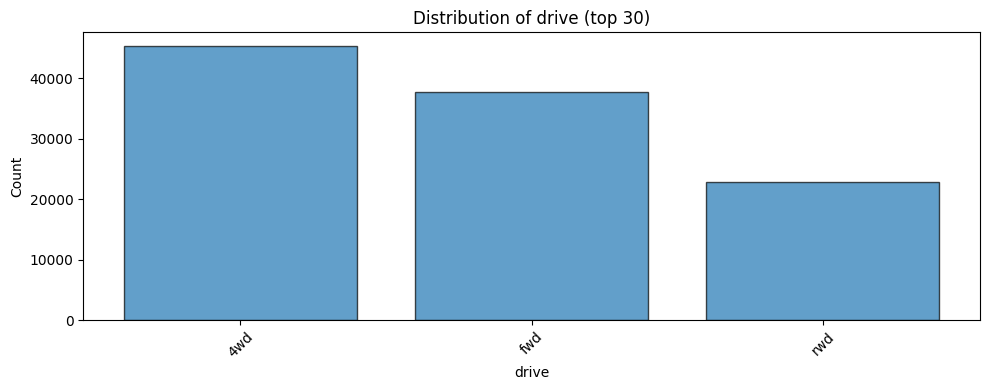

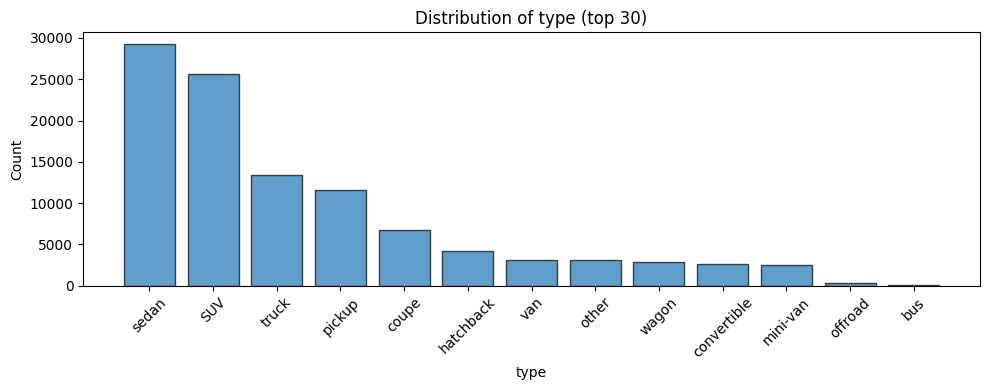

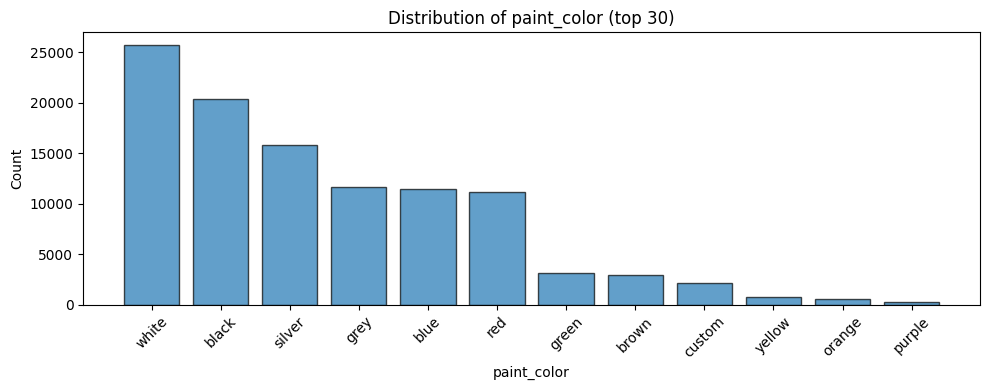

In [259]:
# now let's plot the distribution of the new features
plot_feature_distribution(df)

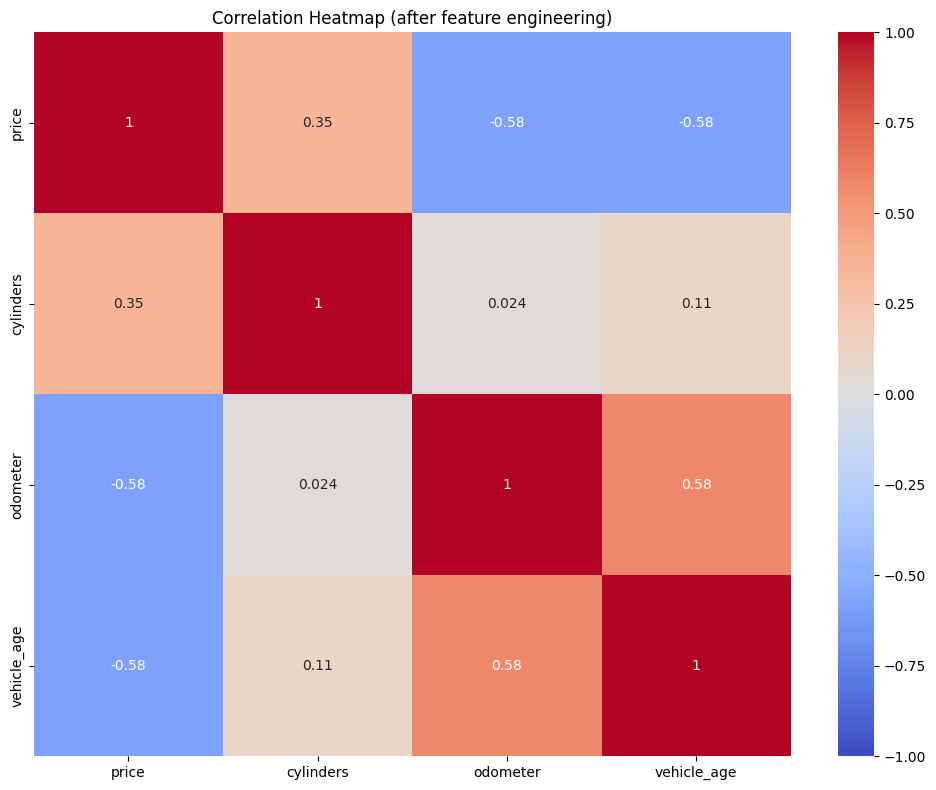

In [260]:
plot_heatmap(df, 'Correlation Heatmap (after feature engineering)')

In [261]:
#print out min and max values for all numerical features
min_max_info(df)

#print out distinct values for all categorical features
distinct_info(df)


               price  |  min:            1.00  |  max:       58,800.00
           cylinders  |  min:            0.00  |  max:           12.00
            odometer  |  min:            0.00  |  max:      283,465.00
         vehicle_age  |  min:            4.00  |  max:           36.00
        manufacturer  |  distinct: ['acura', 'alfa-romeo', 'aston-martin', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ferrari', 'fiat', 'ford', 'gmc', 'harley-davidson', 'honda', 'hyundai', 'infiniti', 'jaguar', 'jeep', 'kia', 'land rover', 'lexus', 'lincoln', 'mazda', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan', 'pontiac', 'porsche', 'ram', 'rover', 'saturn', 'subaru', 'tesla', 'toyota', 'volkswagen', 'volvo']
               model  |  distinct: ['#NAME?', '& altima', '(cng) 2500 express van', '* vmi * ♿', '- 328i - convertible', '-150 xlt', '-300', '/ accord', '/ braun', '/ durango sport', '/ vmi / ♿', '// vmi // ♿', '// vmi ♿', '/vmi conversion van', '1 series 12

In [262]:
print(f"Shape before additional filtering: {df.shape}")

df = df[df['cylinders'] > 0]
df = df[df['odometer'] > 0]

# df = df[df['transmission'] != 'other']

# df = df[df['title_status'].isin(['clean', 'rebuilt', 'lien'])]

# df = df[df['condition'] != 'new']
# df = df[df['condition'] != 'salvage']

# df = df[df['fuel'] != 'electric']
# df = df[df['fuel'] != 'hybrid']
# df = df[df['fuel'] != 'other']

# df = df[df['type'] != 'offroad']
# df = df[df['type'] != 'bus']
# df = df[df['type'] != 'other']

print(f"Shape after additional filtering:  {df.shape}")

Shape before additional filtering: (105801, 13)
Shape after additional filtering:  (105383, 13)


In [263]:
# model contains too many unique values, so I drop it
df = df.drop(columns=['model'])


               price  |  min:            1.00  |  max:       58,800.00
           cylinders  |  min:            3.00  |  max:           12.00
            odometer  |  min:            1.00  |  max:      283,465.00
         vehicle_age  |  min:            4.00  |  max:           36.00
        manufacturer  |  distinct: ['acura', 'alfa-romeo', 'aston-martin', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ferrari', 'fiat', 'ford', 'gmc', 'harley-davidson', 'honda', 'hyundai', 'infiniti', 'jaguar', 'jeep', 'kia', 'land rover', 'lexus', 'lincoln', 'mazda', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan', 'pontiac', 'porsche', 'ram', 'rover', 'saturn', 'subaru', 'tesla', 'toyota', 'volkswagen', 'volvo']
           condition  |  distinct: ['excellent', 'fair', 'good', 'like new', 'new', 'salvage']
                fuel  |  distinct: ['diesel', 'electric', 'gas', 'hybrid', 'other']
        title_status  |  distinct: ['clean', 'lien', 'missing', 'parts only', '

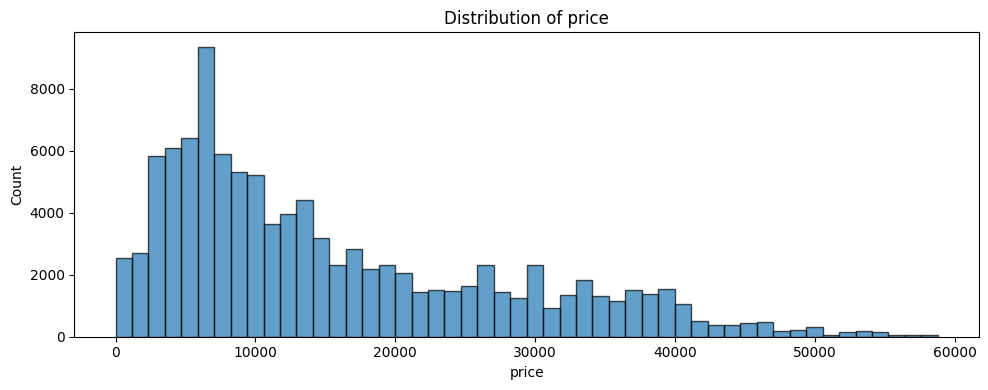

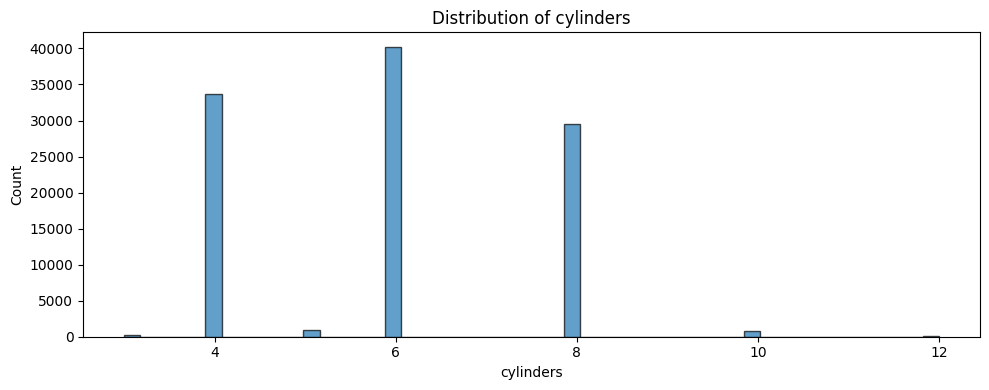

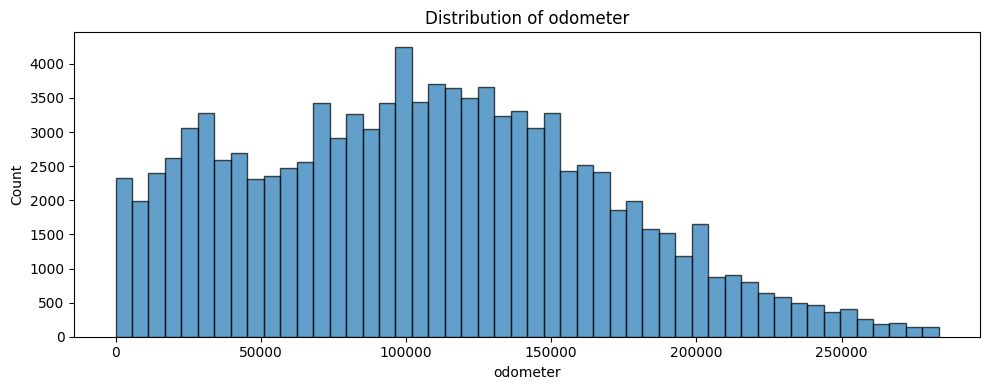

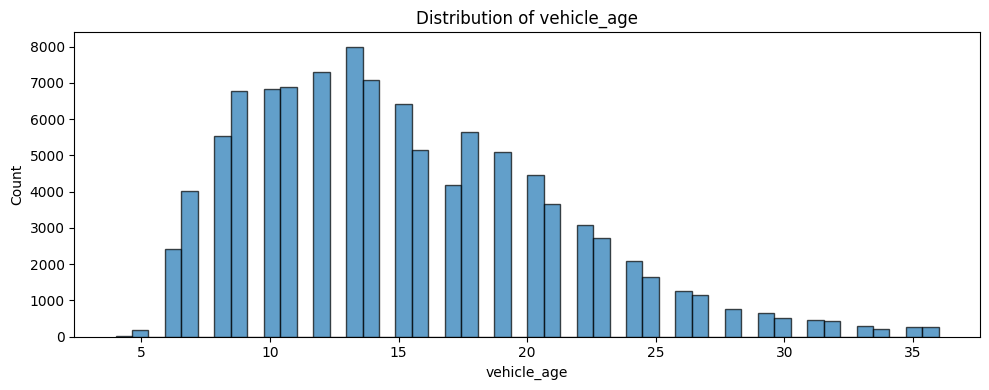

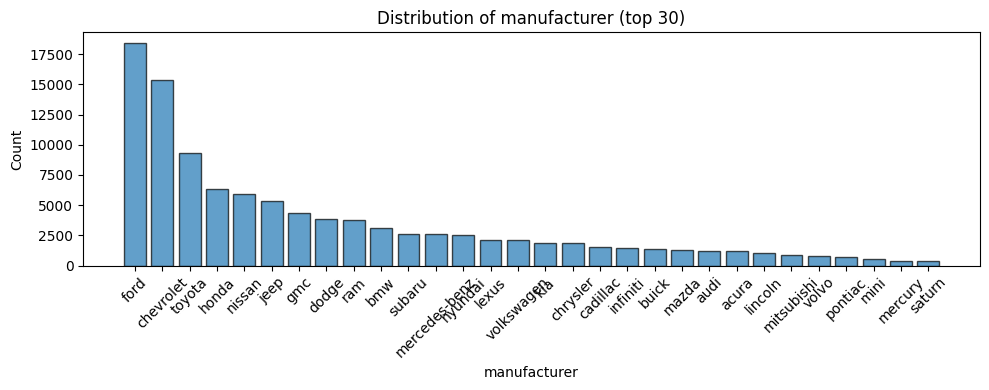

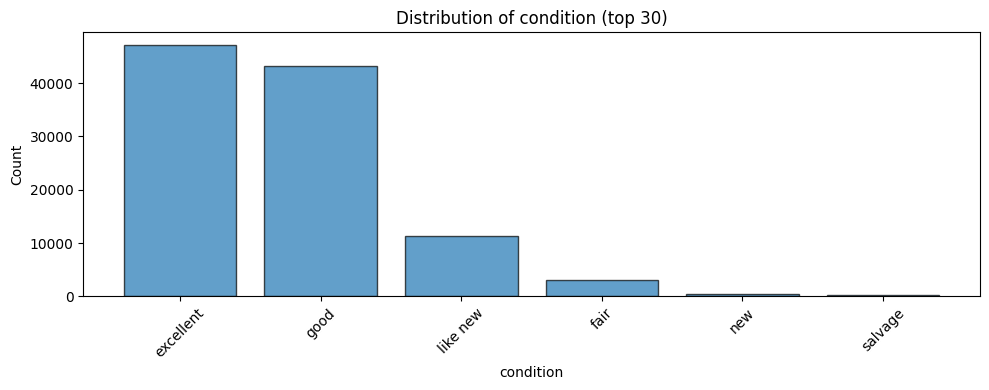

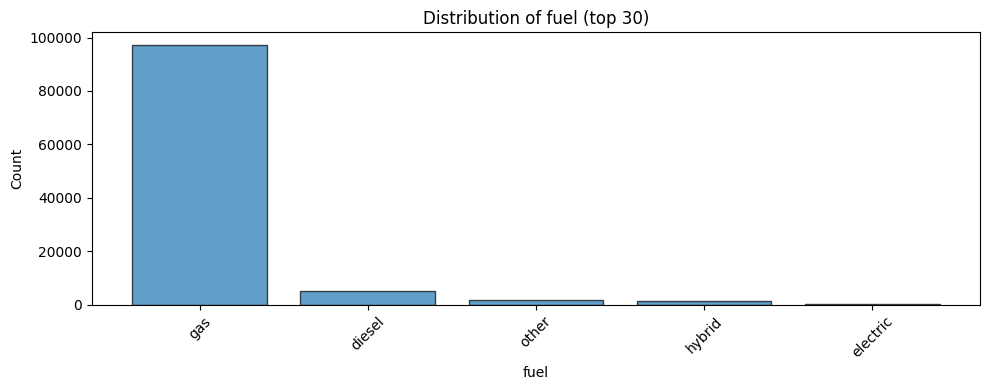

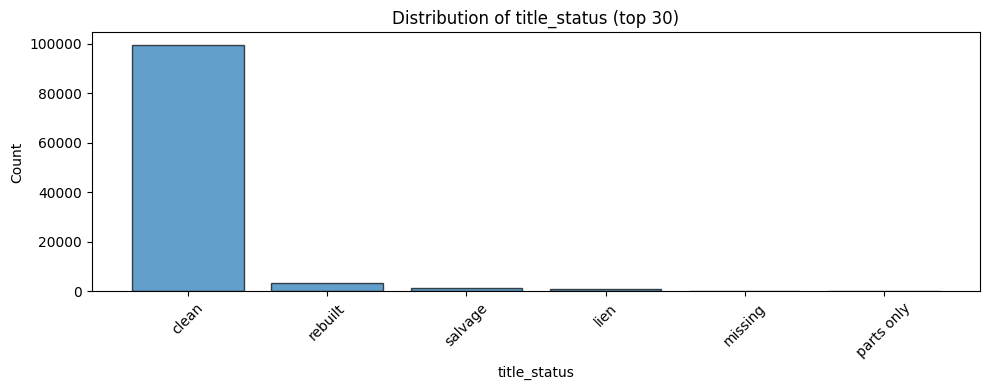

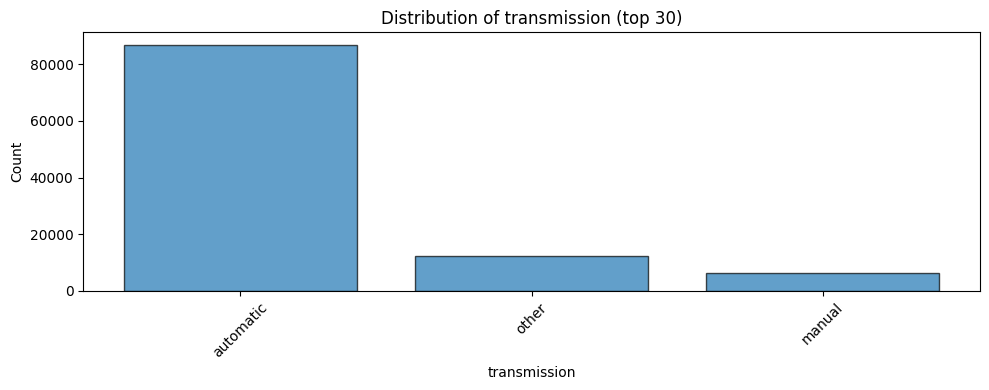

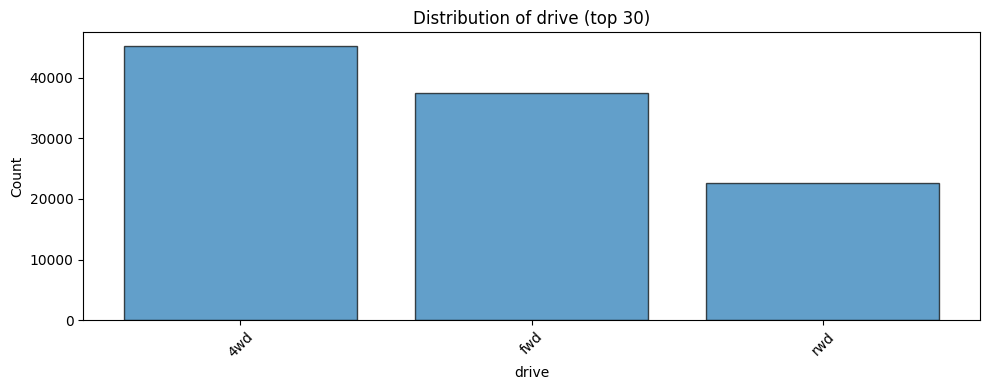

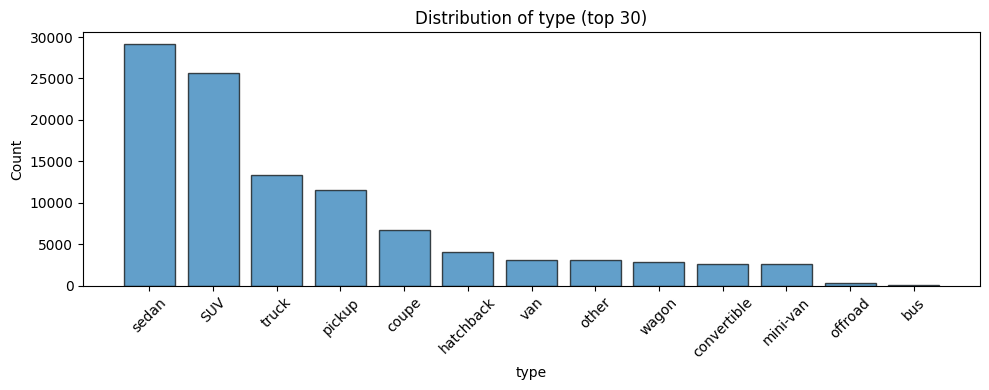

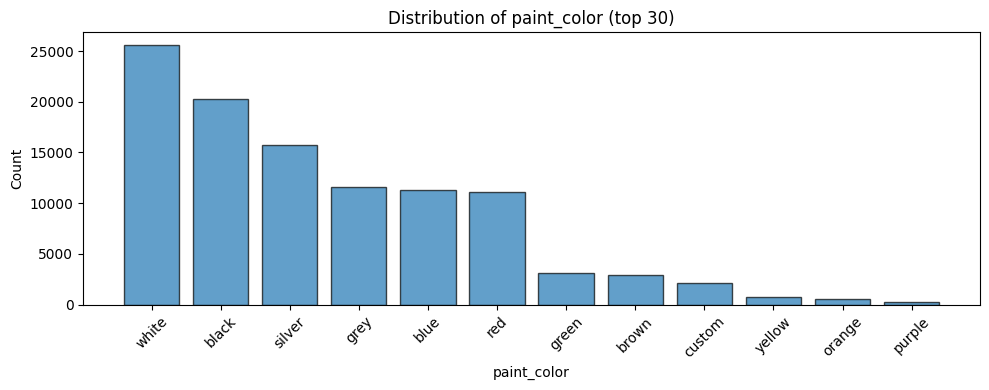

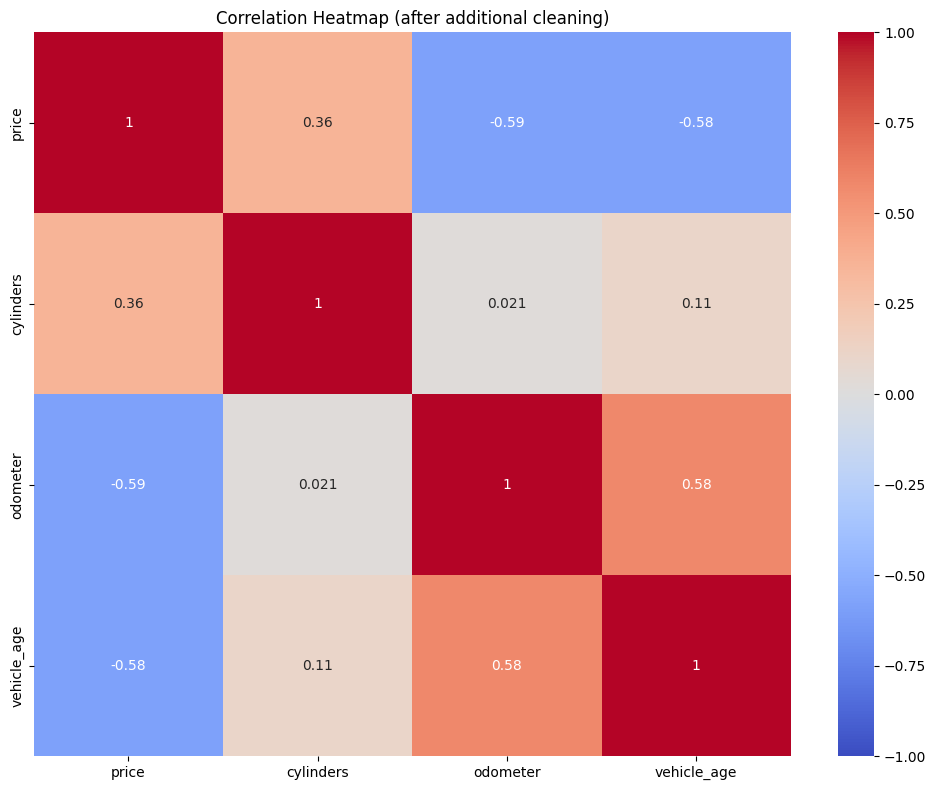

In [264]:
min_max_info(df)

distinct_info(df)

plot_feature_distribution(df)

plot_heatmap(df, 'Correlation Heatmap (after additional cleaning)')


Split dataset 80/20 train/test sets (X_train, X_test, y_train, y_test)


In [265]:
y = df['price']
X = df.drop(columns=['price'])

print(f"Min price: {y.min()}, Max price: {y.max()}")

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"X_train_orig: {X_train_orig.shape}, X_test_orig: {X_test_orig.shape}")
print(f"y_train_orig: {y_train_orig.shape}, y_test_orig: {y_test_orig.shape}")



Min price: 1, Max price: 58800

Final feature matrix shape: (105383, 11)
X_train_orig: (84306, 11), X_test_orig: (21077, 11)
y_train_orig: (84306,), y_test_orig: (21077,)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [266]:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

cat_features = X_train.select_dtypes(include='object').columns.tolist()
num_features = X_train.select_dtypes(include='number').columns.tolist()

print(f"Categorical features ({len(cat_features)}): {cat_features}")
print(f"Numeric features ({len(num_features)}):     {num_features}")

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features),
    ('num', StandardScaler(), num_features),
])

ridge_regressor = create_regressor(Ridge(), preprocessor)

params_dict = {'regressor__model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid = GridSearchCV(ridge_regressor, param_grid=params_dict, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)

best_alpha = grid.best_params_['regressor__model__alpha']
print(f"\nBest Alpha: {best_alpha}")
print_metrics(y_train, train_preds, y_test, test_preds, label="Ridge (all features, log target)")



Categorical features (8): ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
Numeric features (3):     ['cylinders', 'odometer', 'vehicle_age']

Best Alpha: 100.0

--- Ridge (all features, log target) ---
Train MSE:    49,333,460.86  |  Test MSE:    51,323,703.82
Train MAE:         4,701.48  |  Test MAE:         4,759.33
Train RMSE: $      7,023.78  |  Test RMSE: $      7,164.06
Train R²:            0.6671  |  Test R²:            0.6567


{'label': 'Ridge (all features, log target)',
 'train_mse': 49333460.86409547,
 'test_mse': 51323703.81616713,
 'train_mae': 4701.478770443205,
 'test_mae': 4759.330358640069,
 'train_r2': 0.6670991462759649,
 'test_r2': 0.6566701387018301}

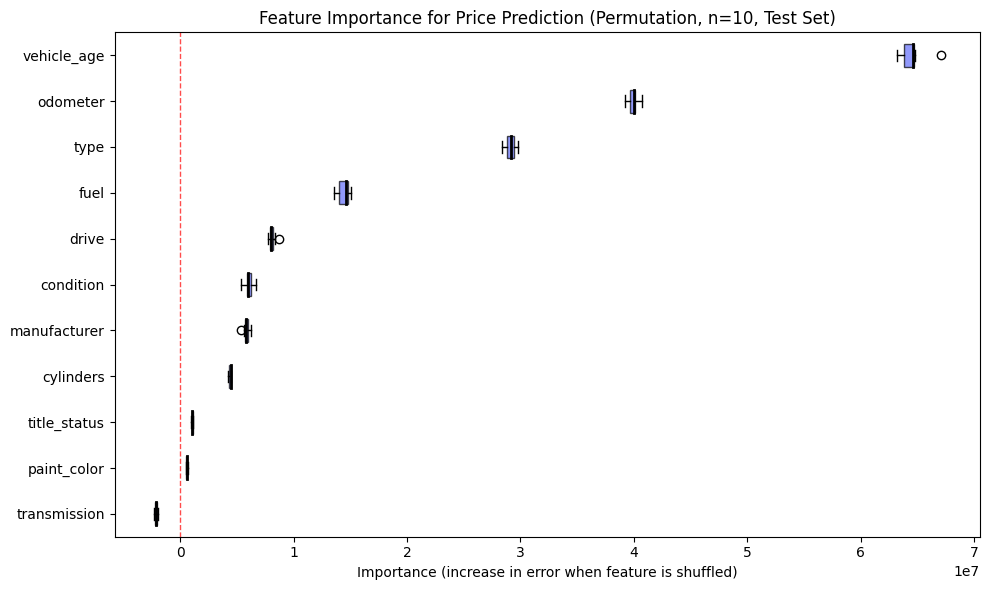


--- Mean Permutation Importance (sorted) ---
           vehicle_age:  64,532,709.31
              odometer:  39,923,928.88
                  type:  29,099,878.40
                  fuel:  14,423,952.15
                 drive:  8,084,585.87
             condition:  5,990,368.35
          manufacturer:  5,839,260.74
             cylinders:  4,405,512.97
          title_status:  1,053,522.70
           paint_color:    586,440.99
          transmission:  -2,133,214.26


In [267]:
from sklearn.inspection import permutation_importance

X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

perm_importance = permutation_importance(
    grid,
    X_test,
    y_test,
    n_repeats=10,
    n_jobs=-1,
    random_state=42,
)

importance_df = pd.DataFrame(
    perm_importance.importances.T,
    columns=X_test.columns
)

sorted_features = importance_df.mean().sort_values(ascending=True).index
importance_sorted = importance_df[sorted_features]

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(
    [importance_sorted[col] for col in importance_sorted.columns],
    vert=False,
    labels=importance_sorted.columns,
    patch_artist=True,
    boxprops=dict(facecolor='#636efa', alpha=0.7),
    medianprops=dict(color='black', linewidth=2),
)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Importance (increase in error when feature is shuffled)')
ax.set_title('Feature Importance for Price Prediction (Permutation, n=10, Test Set)')
plt.tight_layout()
plt.show()

print("\n--- Mean Permutation Importance (sorted) ---")
means = importance_df.mean().sort_values(ascending=False)
for feat, val in means.items():
    print(f"  {feat:>20s}:  {val:>12,.2f}")



#### How to Read the Feature Importance Box Plot

The **permutation importance** box plot shows how much the model's prediction error **increases** when each feature's values are randomly shuffled on the **held-out test set**. A larger increase means the model relies more heavily on that feature. Each feature was shuffled 10 times (`n_repeats=10`), producing a distribution of importance scores — that is what the box-and-whisker visualizes.

Features are sorted from lowest (top) to highest (bottom) mean importance. The **red dashed line at zero** separates informative features (right of zero) from uninformative ones (left of zero).

**How to read it:**
- **Box far to the right** — the model relies heavily on this feature; shuffling it destroys a lot of predictive power.
- **Box near zero** — the feature contributes very little.
- **Box left of zero** — noise; shuffling sometimes *helped* the model, meaning the feature is uninformative or harmful.
- **Narrow boxes** — stable, reliable contribution across all 10 shuffles.
- **Wide boxes** — unstable importance, suggesting interactions or noise.

---

#### Feature Rankings (from permutation importance)

| Rank | Feature | Mean Importance | Interpretation |
|------|---------|----------------|----------------|
| 1 | **vehicle_age** | 64,532,709 | By far the strongest predictor. Newer vehicles command significantly higher prices. |
| 2 | **odometer** | 39,923,929 | Second strongest. Lower mileage = higher price — a continuous, near-linear relationship. |
| 3 | **type** | 29,099,878 | Vehicle body type matters — trucks, SUVs, and pickups hold value better than sedans. |
| 4 | **fuel** | 14,423,952 | Fuel type influences price; diesel vehicles tend to hold value in truck/towing markets. |
| 5 | **drive** | 8,084,586 | 4WD/AWD commands a premium over FWD, especially in harsh-weather regions. |
| 6 | **condition** | 5,990,368 | "Excellent" and "like new" fetch higher prices than "good" or "fair." |
| 7 | **manufacturer** | 5,839,261 | Brand premiums exist (Toyota, Lexus, Porsche hold value). |
| 8 | **cylinders** | 4,405,513 | Engine size correlates with vehicle value, especially for trucks. |
| 9 | **title_status** | 1,053,523 | Clean titles are worth more, but after filtering to clean/rebuilt/lien, the variation is small. |
| 10 | **paint_color** | 586,441 | Minimal effect — color barely matters for pricing. |
| 11 | **transmission** | −2,133,214 | Negative importance — shuffling it *improved* predictions. This feature adds noise, not signal. |

---

#### Key Takeaway

**`vehicle_age` and `odometer` are the two dominant price drivers**, together accounting for far more importance than all other features combined. This aligns with domain knowledge: the used car market fundamentally prices vehicles based on how old they are and how many miles they have been driven. All other features play supporting roles.

In [268]:
model_results = []

X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

drop_features = ['transmission']
keep_features = [f for f in X_train.columns if f not in drop_features]
print(f"Dropped: {drop_features}")
print(f"Keeping: {keep_features}\n")

X_train_keep = X_train[keep_features]
X_test_keep = X_test[keep_features]

ridge_params = {'regressor__model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_keep, metrics = run_model(
    Ridge(), X_train_keep, y_train, X_test_keep, y_test,
    label="Ridge",
    param_grid=ridge_params,
)
model_results.append(metrics)

Dropped: ['transmission']
Keeping: ['manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'drive', 'type', 'paint_color', 'vehicle_age']

Features (7 cat + 3 num): ['manufacturer', 'condition', 'fuel', 'title_status', 'drive', 'type', 'paint_color', 'cylinders', 'odometer', 'vehicle_age']
Best params: {'regressor__model__alpha': 0.001}

--- Ridge ---
Train MSE:    46,956,973.61  |  Test MSE:    48,447,678.38
Train MAE:         4,551.97  |  Test MAE:         4,583.69
Train RMSE: $      6,852.52  |  Test RMSE: $      6,960.44
Train R²:            0.6831  |  Test R²:            0.6759


Try Lasso

In [269]:
from sklearn.linear_model import Lasso

_, metrics = run_model(
    Lasso(), X_train_keep, y_train, X_test_keep, y_test,
    label="Lasso",
    param_grid={'regressor__model__alpha': [0.001, 0.1, 1.0, 10.0]},
)
model_results.append(metrics)

Features (7 cat + 3 num): ['manufacturer', 'condition', 'fuel', 'title_status', 'drive', 'type', 'paint_color', 'cylinders', 'odometer', 'vehicle_age']
Best params: {'regressor__model__alpha': 0.001}

--- Lasso ---
Train MSE:    47,347,840.86  |  Test MSE:    48,793,456.21
Train MAE:         4,566.70  |  Test MAE:         4,594.46
Train RMSE: $      6,880.98  |  Test RMSE: $      6,985.23
Train R²:            0.6805  |  Test R²:            0.6736


Try Random Forest

In [270]:
from sklearn.ensemble import RandomForestRegressor

_, metrics = run_model(
    RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=5,
                          n_jobs=-1, random_state=42),
    X_train_keep, y_train, X_test_keep, y_test,
    label="Random Forest",
)
model_results.append(metrics)


Features (7 cat + 3 num): ['manufacturer', 'condition', 'fuel', 'title_status', 'drive', 'type', 'paint_color', 'cylinders', 'odometer', 'vehicle_age']

--- Random Forest ---
Train MSE:    19,914,273.52  |  Test MSE:    25,631,947.78
Train MAE:         2,674.22  |  Test MAE:         2,988.41
Train RMSE: $      4,462.54  |  Test RMSE: $      5,062.80
Train R²:            0.8656  |  Test R²:            0.8285


### Evaluation

With some modeling accomplished, I aim to reflect on what I identify as a high-quality model and what I am able to learn from this.  I should review my business objective and explore how well I can provide meaningful insight into drivers of used car prices.  My goal now is to distill my findings and determine whether the earlier phases need revisitation and adjustment or if I have information of value to bring back to my client.

MODEL COMPARISON — Top Features, Log-Transformed Target
                   Test MSE  Test MAE ($)  Test RMSE ($)   Test R²  Train R²  Overfit Gap (R²)
Model                                                                                         
Ridge          4.844768e+07   4583.685645    6960.436652  0.675909  0.683136          0.007226
Lasso          4.879346e+07   4594.462433    6985.231293  0.673596  0.680498          0.006902
Random Forest  2.563195e+07   2988.406308    5062.800389  0.828535  0.865619          0.037084

Best model by Test R²: Random Forest  (R² = 0.8285)
  → Average prediction error (MAE): $2,988
  → Overfit gap: 0.0371

All three models agree: vehicle_age and odometer are the dominant price drivers.


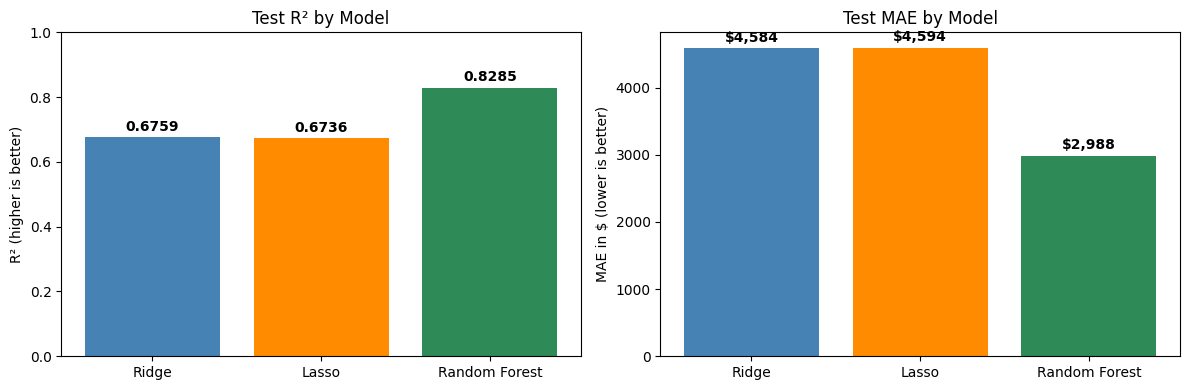

In [271]:
def compare_models(model_results):
    """Build a comparison DataFrame from model_results and display summary + charts."""
    rows = []
    for m in model_results:
        rows.append({
            'Model': m['label'],
            'Test MSE': m['test_mse'],
            'Test MAE ($)': m['test_mae'],
            'Test RMSE ($)': np.sqrt(m['test_mse']),
            'Test R²': m['test_r2'],
            'Train R²': m['train_r2'],
        })

    comparison = pd.DataFrame(rows).set_index('Model')
    comparison['Overfit Gap (R²)'] = comparison['Train R²'] - comparison['Test R²']

    print("=" * 80)
    print("MODEL COMPARISON — Top Features, Log-Transformed Target")
    print("=" * 80)
    print(comparison.to_string())
    print()

    best = comparison['Test R²'].idxmax()
    print(f"Best model by Test R²: {best}  (R² = {comparison.loc[best, 'Test R²']:.4f})")
    print(f"  → Average prediction error (MAE): ${comparison.loc[best, 'Test MAE ($)']:,.0f}")
    print(f"  → Overfit gap: {comparison.loc[best, 'Overfit Gap (R²)']:.4f}")
    print()
    print("All three models agree: vehicle_age and odometer are the dominant price drivers.")

    colors = ['steelblue', 'darkorange', 'seagreen', 'firebrick', 'mediumpurple']
    bar_colors = colors[:len(comparison)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    models = comparison.index.tolist()
    x = range(len(models))

    axes[0].bar(x, comparison['Test R²'], color=bar_colors)
    axes[0].set_xticks(list(x))
    axes[0].set_xticklabels(models)
    axes[0].set_ylabel('R² (higher is better)')
    axes[0].set_title('Test R² by Model')
    axes[0].set_ylim(0, 1)
    for i, v in enumerate(comparison['Test R²']):
        axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

    axes[1].bar(x, comparison['Test MAE ($)'], color=bar_colors)
    axes[1].set_xticks(list(x))
    axes[1].set_xticklabels(models)
    axes[1].set_ylabel('MAE in $ (lower is better)')
    axes[1].set_title('Test MAE by Model')
    for i, v in enumerate(comparison['Test MAE ($)']):
        axes[1].text(i, v + 100, f'${v:,.0f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return comparison

comparison = compare_models(model_results)

#### Evaluation Summary

**Business objective**: Identify the key drivers of used car prices so a dealership can make smarter inventory and pricing decisions.

**Do my models provide meaningful insight?** Yes. All three models achieve positive R² on the held-out test set, confirming that the features I selected have real predictive power over price.

| Model | Test R² | Test MAE | Overfit Gap |
|-------|---------|----------|-------------|
| Ridge | 0.676 | $4,584 | 0.007 |
| Lasso | 0.674 | $4,594 | 0.007 |
| **Random Forest** | **0.829** | **$2,988** | 0.037 |

**Best model**: Random Forest — it explains ~83% of price variance with an average error of ~$3,000 per vehicle. Ridge and Lasso are simpler and more interpretable but explain only ~68%.

**Key findings across all models**:
1. **`vehicle_age`** and **`odometer`** are the two dominant price drivers, far outweighing all other features (confirmed by permutation importance).
2. `type`, `fuel`, and `drive` play meaningful secondary roles.
3. `transmission` was dropped as it added noise (negative permutation importance).

**Do earlier phases need revisiting?** The current pipeline is sound — data cleaning, outlier removal, and feature selection produced stable, interpretable results. Potential improvements:
- Enrich the dataset with vehicle trim, accident history, and number of owners.
- Train separate models per vehicle segment (trucks vs. sedans) for tighter predictions.
- Tune Random Forest hyperparameters further or try gradient boosting.

**Bottom line**: I have actionable information for the client — **newer, lower-mileage vehicles command the highest prices**, and the dealership should prioritize these in acquisitions.

### Deployment

Now that I've settled on my models and findings, it is time to deliver the information to the client.  I should organize my work as a basic report that details my primary findings.  Keep in mind that my audience is a group of used car dealers interested in fine-tuning their inventory.

## Report to Client: What Drives Used Car Prices?

Dear Dealership Team,

I analyzed over 400,000 used vehicle listings to answer one question: **what makes a used car worth more or less?** Here are my findings.

---

### The Two Biggest Price Drivers

1. **Vehicle Age** — the single most important factor. Newer cars sell for significantly more. Each additional year of age reduces value substantially.
2. **Odometer (Mileage)** — the second most important factor. Lower mileage means higher price, and the relationship is nearly linear.

These two features alone account for far more predictive power than all other features combined.

---

### Other Factors That Matter

| Factor | Impact |
|--------|--------|
| **Vehicle Type** | Trucks, SUVs, and pickups hold value better than sedans. |
| **Fuel Type** | Diesel vehicles retain value, especially in truck/towing markets. |
| **Drive Type** | 4WD/AWD commands a premium over FWD. |
| **Condition** | "Excellent" and "like new" fetch noticeably higher prices than "fair." |
| **Manufacturer** | Toyota, Honda, and luxury brands hold value best. |
| **Cylinders** | Larger engines (6, 8 cyl) correlate with higher-value vehicles. |
| **Paint Color** | Minimal impact — color barely matters for pricing. |
| **Transmission** | No meaningful impact — I dropped it from my final models. |

---

### How Confident Am I?

I tested three different models. My best model (Random Forest) explains **~83% of price variation** with an average prediction error of about **$3,000** per vehicle. The simpler models (Ridge and Lasso regression) explain ~68% of variation with ~$4,600 average error. All three models agree on the same feature rankings.

---

### Recommendations for Your Dealership

1. **Prioritize newer, low-mileage inventory.** These are the two factors that matter most — by a wide margin.
2. **Stock trucks, SUVs, and pickups.** They hold value better and have stronger resale demand.
3. **Favor brands with strong resale value** — Toyota, Honda, and select luxury brands.
4. **Invest in reconditioning.** Moving a vehicle from "fair" to "good" condition yields measurable price uplift.
5. **Don't overpay for color or transmission type.** These have negligible effect on what buyers will pay.

---

*Analysis performed using Ridge Regression, Lasso Regression, and Random Forest models with log-transformed target pricing and permutation-based feature importance.*